<a href="https://colab.research.google.com/github/opticalcode/Hachioji-AI-biginner/blob/master/%E9%A1%A7%E5%AE%A2%E9%9B%A2%E5%8F%8D%E4%BA%88%E6%B8%AC%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E7%B5%90%E6%9E%9C%E3%82%92SHAP%E3%82%92%E4%BD%BF%E3%81%A3%E3%81%A6%E8%A7%A3%E9%87%88%E3%81%99%E3%82%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kaggle/Telco Customer Churn/The raw data contains 7043 rows (customers) and 21 columns (features).

(顧客離反データセットのインポート）

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd 
data= pd.read_csv('drive/My Drive/dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


SHAP（SHapley Additive exPlanations）のインストール

In [5]:
pip install shap

データセットの準備と前処理

In [6]:
import shap
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
shap.initjs()
 
df = pd.read_csv("drive/My Drive/dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
# 欠損値をNONEで埋める
df['customerID'] = df['customerID'].fillna('NONE')
df['gender'] = df['gender'].fillna('NONE')
df['SeniorCitizen'] = df['SeniorCitizen'].fillna('NONE')
df['Partner'] = df['Partner'].fillna('NONE')
df['Dependents'] = df['Dependents'].fillna('NONE')
df['tenure'] = df['tenure'].fillna('NONE')
df['PhoneService'] = df['PhoneService'].fillna('NONE')
df['MultipleLines'] = df['MultipleLines'].fillna('NONE')
df['InternetService'] = df['InternetService'].fillna('NONE')
df['OnlineSecurity'] = df['OnlineSecurity'].fillna('NONE')
df['OnlineBackup'] = df['OnlineBackup'].fillna('NONE')
df['DeviceProtection'] = df['DeviceProtection'].fillna('NONE')
df['TechSupport'] = df['TechSupport'].fillna('NONE')
df['StreamingTV'] = df['StreamingTV'].fillna('NONE')
df['StreamingMovies'] = df['StreamingMovies'].fillna('NONE')
df['Contract'] = df['Contract'].fillna('NONE')
df['PaperlessBilling'] = df['PaperlessBilling'].fillna('NONE')
df['PaymentMethod'] = df['PaymentMethod'].fillna('NONE')
df['MonthlyCharges'] = df['MonthlyCharges'].fillna('NONE')
df['TotalCharges'] = df['TotalCharges'].fillna('NONE')
df['TotalCharges'] = df['TotalCharges'].fillna('NONE')

In [8]:
# 目的変数のバイナリ化
class_mapping = {'No':0, 'Yes':1}
df['Churn'] = df['Churn'].map(class_mapping)

In [9]:
# 説明変数のラベルエンコーディング
from sklearn import preprocessing
 
encode_list = ['customerID',
                      'gender',
                      'Partner',
                      'Dependents',
                      'PhoneService',
                      'MultipleLines',
                      'InternetService',
                      'OnlineSecurity',
                      'OnlineBackup',
                      'DeviceProtection',
                      'TechSupport',
                      'StreamingTV',
                      'StreamingMovies',
                      'Contract',
                      'PaperlessBilling',
                      'PaymentMethod',
                      'TotalCharges']
 
for column in encode_list:
    print(column)
    le = preprocessing.LabelEncoder()
    le.fit(df[column])
    df[column] = le.transform(df[column])

customerID
gender
Partner
Dependents
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
TotalCharges


モデルの作成

In [10]:
train_data, valid_data = train_test_split(df, test_size=0.2, random_state = 1)
y_train = train_data["Churn"]
X_train = train_data[["gender", "SeniorCitizen", "Partner", "Dependents", "tenure", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod", "MonthlyCharges", "TotalCharges"]]
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
from sklearn.metrics import  accuracy_score
y_valid = valid_data["Churn"]
X_valid = valid_data[["gender", "SeniorCitizen", "Partner", "Dependents", "tenure", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod", "MonthlyCharges", "TotalCharges"]]
pred = clf.predict(X_valid)
print(accuracy_score(np.round(pred),y_valid))

0.8140525195173882


SHAPによる結果を可視化

In [11]:
explainer = shap.TreeExplainer(model=clf)
shap_values = explainer.shap_values(X=X_valid)

Force Plotによる可視化

In [12]:
shap.initjs()
i = 8
shap.force_plot(explainer.expected_value, shap_values[i, :], X_valid.iloc[i,:], link="logit")

In [13]:
shap.initjs()
s = 0
e = 200
shap.force_plot(explainer.expected_value, shap_values[s:e, :], X_valid.iloc[s:e, :], link="logit")

Decision Plotによる可視化

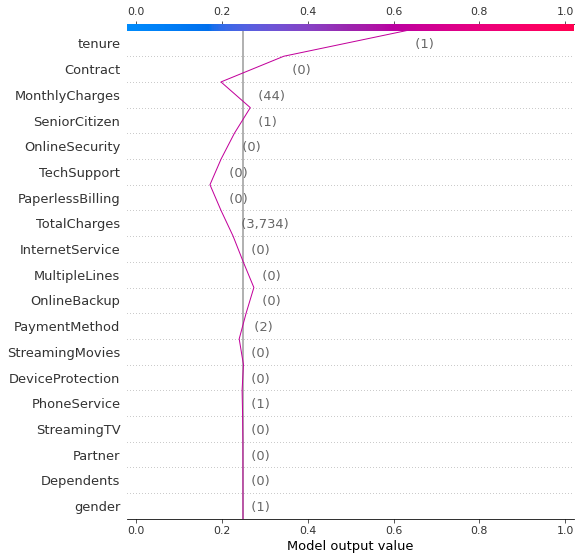

In [14]:
shap.initjs()
misclassified = (np.round(pred) != y_valid)
shap.decision_plot(explainer.expected_value, shap_values[7:8], X_valid[7:8], link="logit",highlight=misclassified[0:1])

Summary Plotによる可視化

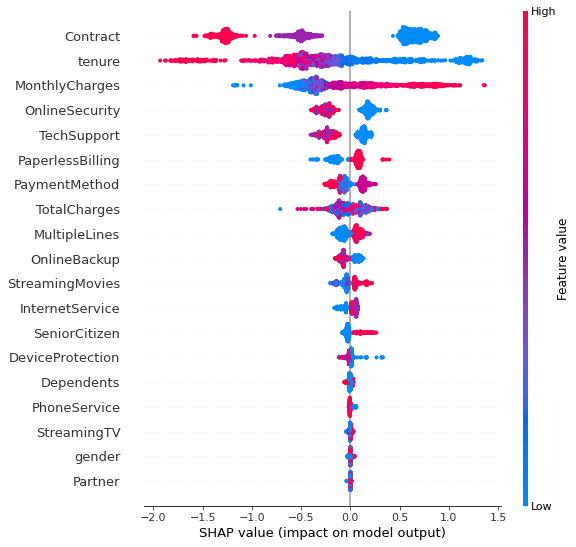

In [15]:
shap.initjs()
shap.summary_plot(shap_values, X_valid)